In [17]:
from models import ACVNet
import torchvision.transforms as transforms
import torch
from PIL import Image
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import time
import cv2

In [27]:
def testing(imgL, imgR, cpu=True):
    if cpu:
        device = torch.device('cpu')
    else:
        device = torch.device('cuda:0')

    t = transforms.Compose([
        transforms.ToTensor(),
        #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # load model
    model = ACVNet(192, False, False)
    state_dict = torch.load("pretrained_model/pretrained_model_sceneflow.ckpt", map_location="cpu")
    model_dict = model.state_dict()
    pre_dict = {k[7:]: v for k, v in state_dict['model'].items() if k[7:] in model_dict}
    model_dict.update(pre_dict) 
    model.load_state_dict(model_dict)
    model = model.to(device)

    w, h = imgL.size

    start = time.time()

    imgL = t(imgL).numpy()
    imgR = t(imgR).numpy()

    top_pad = 384 - h
    right_pad = 1248 - w
    assert top_pad > 0 and right_pad > 0
    # pad images
    left_img = np.lib.pad(imgL, ((0, 0), (top_pad, 0), (0, right_pad)), mode='constant', constant_values=0)
    right_img = np.lib.pad(imgR, ((0, 0), (top_pad, 0), (0, right_pad)), mode='constant',
                            constant_values=0)

    left_img = torch.tensor(left_img).unsqueeze(0).to(device)
    right_img = torch.tensor(right_img).unsqueeze(0).to(device)
    # testing 

    model.eval()
    with torch.no_grad():
        
        dist = model(left_img, right_img)
    
    disp_est = np.array((dist[-1][0].detach().cpu().numpy())[top_pad:, :-right_pad], dtype=np.float32)
    disp_est_uint = np.round(disp_est).astype(np.uint8)

    end = time.time()
    print("執行時間：%f 秒" % (end - start))
    return disp_est_uint

### tsukuba

/home/alright/miniconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/functional.py:3328: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/alright/miniconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


執行時間：9.172112 秒


True

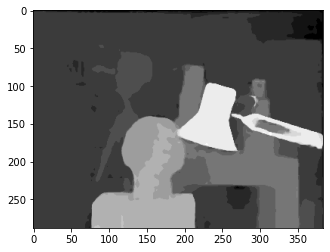

In [35]:
imgL = Image.open('test image/tsukuba/tsukuba_imL.png').convert('RGB')
imgR = Image.open('test image/tsukuba/tsukuba_imR.png').convert('RGB')

disp = testing(imgL, imgR, cpu=True)
plt.imshow(disp, cmap="gray")
disp = disp / np.max(disp) * 255
cv2.imwrite('result/tsukuba_acvnet.png', disp)

### cones

執行時間：9.184048 秒


True

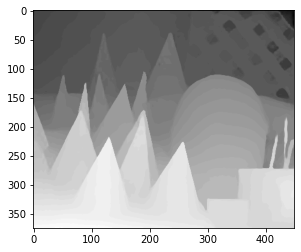

In [36]:
imgL = Image.open('test image/cones/cones_imL.png').convert('RGB')
imgR = Image.open('test image/cones/cones_imR.png').convert('RGB')

disp = testing(imgL, imgR, cpu=True)
plt.imshow(disp, cmap="gray")
disp = disp / np.max(disp) * 255
cv2.imwrite('result/cones_acvnet.png', disp)